# Ultralytics YOLO v3 객체 탐지 훈련 실습(Oxford Pet 데이터 활용)

## Ultralytics YOLO v3 다운로드 및 필요 라이브러리 설치

In [1]:
# Ultralytics YOLO v3 다운로드
!git clone https://github.com/ultralytics/yolov3
# 필요 라이브러리 설치
!cd yolov3; pip install -qr requirements.txt

Cloning into 'yolov3'...
remote: Enumerating objects: 10002, done.
remote: Total 10002 (delta 0), reused 0 (delta 0), pack-reused 10002
Receiving objects: 100% (10002/10002), 9.33 MiB | 30.14 MiB/s, done.
Resolving deltas: 100% (6747/6747), done.
     |████████████████████████████████| 596 kB 5.0 MB/s 
     |████████████████████████████████| 1.8 MB 62.8 MB/s 
     |████████████████████████████████| 181 kB 60.4 MB/s 
     |████████████████████████████████| 144 kB 31.5 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


In [2]:
import torch

print(f'파이토치 버전 : {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else "CPU"})')

파이토치 버전 : 1.11.0+cu113 (Tesla P100-PCIE-16GB)


## Oxford Pet 데이터셋 다운로드
* Oxford Pet 데이터셋 다운로드 후 /content/data 디렉터리에 압축 해제

In [3]:
# Oxford Pet 이미지 데이터
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# Oxford Pet annotataion 데이터
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2022-04-29 01:11:58--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  31.2MB/s    in 25s     

2022-04-29 01:12:23 (29.9 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2022-04-29 01:12:24--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  14.5MB/s    in 1.3s    

2022-04-29 01:12:25 (14.5 M

In [4]:
from IPython.display import clear_output

# /content/data 디렉터리를 만들고 해당 디렉터리에 다운로드한 압축 파일 해제
!mkdir /content/data
!tar -xvf images.tar.gz -C /content/data
!tar -xvf annotations.tar.gz -C /content/data

clear_output()

## 데이터 준비
### 1. Oxford Pet 데이터셋을 훈련/검증 데이터셋으로 분리

In [5]:
# images, labels 디렉터리 생성 후 각 디렉터리에 train, val 디렉터리 생성
!mkdir /content/ox_pet;
!cd /content/ox_pet; mkdir images; mkdir labels;
!cd /content/ox_pet/images; mkdir train; mkdir val
!cd /content/ox_pet/labels; mkdir train; mkdir val

In [6]:
import pandas as pd 

df_temp = pd.read_csv('/content/data/annotations/trainval.txt', sep=' ', header=None, names=['img_name', 'class_id', 'etc1', 'etc2'])
df_temp.head()

,img_name,class_id,etc1,etc2
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [7]:
df_temp['class_name'] = df_temp['img_name'].apply(lambda x:x[:x.rfind('_')])
df_temp.head()

,img_name,class_id,etc1,etc2,class_name
0,Abyssinian_100,1,1,1,Abyssinian
1,Abyssinian_101,1,1,1,Abyssinian
2,Abyssinian_102,1,1,1,Abyssinian
3,Abyssinian_103,1,1,1,Abyssinian
4,Abyssinian_104,1,1,1,Abyssinian


In [8]:
def remove_no_annos(df):
  '''annotation xml 파일이 없는데 df에 있는 경우, df에서 삭제'''
  remove_rows = []
  for index, row in df.iterrows():
    anno_filepath = row['anno_filepath']
    if not os.path.exists(anno_filepath):
      print('### index:', index, anno_filepath, '가 없어서 Dataframe에서 삭제')
      # 해당 DataFrame 인덱스를 remove_rows 리스트에 추가
      remove_rows.append(index)
  # DataFrame의 인덱스가 담긴 리스트를 drop() 메세드에 입력해 해당 rows를 삭제
  df = df.drop(remove_rows)
  return df

In [9]:
import os
import pandas as pd 
from sklearn.model_selection import train_test_split

def make_train_valid_df(txt_filepath, img_dir, anno_dir, test_size=0.1):
  '''전체 image/annotation 파일명을 갖는 txt 파일을 입력 받아 메타 파일용 형태로 훈련/검증용 DataFrame 생성'''
  # txt 파일을 df로 변환 ---①
  pet_df = pd.read_csv(txt_filepath, sep=' ', header=None, names=['img_name', 'class_id', 'etc1', 'etc2'])
  
  # 클래스명은 이미지 파일명에서 맨 마지막 '_' 문자열 앞까지에 해당 ---②
  pet_df['class_name'] = pet_df['img_name'].apply(lambda x:x[:x.rfind('_')])
  
  # 이미지와 annotation 파일의 절대 경로 추가 ---③
  pet_df['img_filepath'] = img_dir + pet_df['img_name']+'.jpg'
  pet_df['anno_filepath'] = anno_dir + pet_df['img_name']+'.xml'

  # annotation xml 파일이 없는데, trainval.txt에는 리스트가 있는 경우가 있음
  # 이 경우 pet_df에서 해당 rows를 삭제
  pet_df = remove_no_annos(pet_df)

  # 훈련/검증 데이터로 분리
  train_df, val_df = train_test_split(pet_df, test_size=test_size, 
                                      stratify=pet_df['class_id'], random_state=2022)
  return pet_df, train_df, val_df

In [10]:
# 메타 파일용 형태로 훈련/검증용 DataFrame 생성
pet_df, train_df, val_df = make_train_valid_df(txt_filepath='/content/data/annotations/trainval.txt', 
                                               img_dir='/content/data/images/', 
                                               anno_dir='/content/data/annotations/xmls/', 
                                               test_size=0.1)

### index: 4 /content/data/annotations/xmls/Abyssinian_104.xml 가 없어서 Dataframe에서 삭제
### index: 262 /content/data/annotations/xmls/Bengal_111.xml 가 없어서 Dataframe에서 삭제
### index: 1456 /content/data/annotations/xmls/samoyed_10.xml 가 없어서 Dataframe에서 삭제
### index: 2128 /content/data/annotations/xmls/Bengal_175.xml 가 없어서 Dataframe에서 삭제
### index: 2395 /content/data/annotations/xmls/Egyptian_Mau_14.xml 가 없어서 Dataframe에서 삭제
### index: 2402 /content/data/annotations/xmls/Egyptian_Mau_156.xml 가 없어서 Dataframe에서 삭제
### index: 2427 /content/data/annotations/xmls/Egyptian_Mau_186.xml 가 없어서 Dataframe에서 삭제
### index: 3177 /content/data/annotations/xmls/Ragdoll_199.xml 가 없어서 Dataframe에서 삭제
### index: 3246 /content/data/annotations/xmls/saint_bernard_15.xml 가 없어서 Dataframe에서 삭제


In [11]:
pet_df.head()

,img_name,class_id,etc1,etc2,class_name,img_filepath,anno_filepath
0,Abyssinian_100,1,1,1,Abyssinian,/content/data/images/Abyssinian_100.jpg,/content/data/annotations/xmls/Abyssinian_100.xml
1,Abyssinian_101,1,1,1,Abyssinian,/content/data/images/Abyssinian_101.jpg,/content/data/annotations/xmls/Abyssinian_101.xml
2,Abyssinian_102,1,1,1,Abyssinian,/content/data/images/Abyssinian_102.jpg,/content/data/annotations/xmls/Abyssinian_102.xml
3,Abyssinian_103,1,1,1,Abyssinian,/content/data/images/Abyssinian_103.jpg,/content/data/annotations/xmls/Abyssinian_103.xml
5,Abyssinian_105,1,1,1,Abyssinian,/content/data/images/Abyssinian_105.jpg,/content/data/annotations/xmls/Abyssinian_105.xml


### 2. Oxford Pet 데이터셋의 annotation을 Ultralytics YOLO 포맷으로 생성

In [12]:
# 클래스명
CLASS_NAMES = pet_df['class_name'].unique().tolist()
print(CLASS_NAMES)

['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [13]:
def convert_yolo_coord(object_name, img_width, img_height, x1, y1, x2, y2):
  '''object_name과 이미지 너비, 높이, 경계 박스 좌표값을 입력받아 YOLO 포맷으로 변환'''
  # CLASS_NAMES 리스트의 인덱스가 class_id ---①
  class_id = CLASS_NAMES.index(object_name)
  
  center_x = (x1 + x2)/2 # 중심 x좌표
  center_y = (y1 + y2)/2 # 중심 y좌표
  width = x2 - x1        # 너비
  height = y2 - y1       # 높이

  # 원본 이미지 크기를 기준으로 중심 좌표와 너비 높이를 0-1 사이 값으로 정규화 ---②
  center_x_norm = center_x / img_width
  center_y_norm = center_y / img_height
  width_norm = width / img_width
  height_norm = height / img_height

  return class_id, round(center_x_norm, 7), round(center_y_norm, 7), round(width_norm, 7), round(height_norm, 7)

In [14]:
import glob
import xml.etree.ElementTree as ET

def xml_to_txt(input_xml_file_path, output_txt_file_path, object_name):
  '''VOC XML 파일을 YOLO 포맷용 txt 파일로 변경해 저장'''
  tree = ET.parse(input_xml_file_path) # xml을 파싱해서 트리 생성 
  root = tree.getroot() # 트리의 루트
  img_size = root.find('size') # 사이즈 노드
  if img_size is None: # img_size를 찾지 못하면 종료
    return None
  # 원본 이미지의 너비와 높이 추출
  img_width = int(img_size.find('width').text)
  img_height = int(img_size.find('height').text)

  with open(output_txt_file_path, 'w') as output_fpointer:
    for obj in root.findall('object'): # 트리에 있는 모든 'object' Element를 찾아 순회
        # bndbox를 찾아 좌상단(xmin, ymin), 우하단(xmax, ymax) 좌표 추출 
        bndbox = obj.find('bndbox')
        x1 = int(bndbox.find('xmin').text)
        y1 = int(bndbox.find('ymin').text)
        x2 = int(bndbox.find('xmax').text)
        y2 = int(bndbox.find('ymax').text)
        # 좌표값 중 0보다 작은 값이 있으면 종료 
        if (x1 < 0) or (x2 < 0) or (y1 < 0) or (y2 < 0):
          break
        # object_name과 이미지 너비, 높이, 경계 박스 좌표값을 전달해 YOLO 포맷으로 변환
        class_id, cx_norm, cy_norm, w_norm, h_norm = convert_yolo_coord(object_name, img_width, 
                                                                    img_height, x1, y1, x2, y2)
        # 변환한 YOLO 좌표를 객체별로 text 파일에 write
        value_str = f'{class_id} {cx_norm} {cy_norm} {w_norm} {h_norm}'
        output_fpointer.write(value_str+'\n')

In [15]:
xml_to_txt(input_xml_file_path='/content/data/annotations/xmls/Abyssinian_1.xml', 
           output_txt_file_path='/content/ox_pet/labels/train/Abyssinian_1.txt', 
           object_name='Abyssinian')

#### 여러 VOC 포맷 파일을 YOLO 포맷으로 변환 후 Ultralytics 디렉터리 구조로 입력

In [16]:
import shutil

def make_yolo_anno_file(df, tgt_images_dir, tgt_labels_dir):
  for index, row in df.iterrows():
    img_filepath = row['img_filepath']
    anno_filepath = row['anno_filepath']
    # 이미지 하나에는 객체 하나만 존재하므로 class_name을 object_name으로 지정
    object_name = row['class_name']
    # YOLO 포맷으로 annotation txt 파일의 절대 경로 지정
    tgt_label_path = tgt_labels_dir + row['img_name']+'.txt'

    # 이미지는 tgt_images_dir 디렉터리로 단순 복사
    shutil.copy(img_filepath, tgt_images_dir)
    # annotation은 YOLO 포맷으로 변환해 tgt_label_path 디렉터리에 저장
    xml_to_txt(anno_filepath, tgt_label_path, object_name)

In [17]:
# 훈련용 이미지, annotation 생성
make_yolo_anno_file(train_df, '/content/ox_pet/images/train/', '/content/ox_pet/labels/train/')
# 검증용 이미지, annotation 생성
make_yolo_anno_file(val_df, '/content/ox_pet/images/val/', '/content/ox_pet/labels/val/')

## 모델 훈련

### 1. 디렉터리 구조에 맞는 yaml 파일 다운로드

In [18]:
!wget -O /content/ox_pet/ox_pet.yaml https://raw.githubusercontent.com/chulminkw/DLCV/master/data/util/ox_pet.yaml

--2022-04-29 01:12:40--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/util/ox_pet.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 754 [text/plain]
Saving to: ‘/content/ox_pet/ox_pet.yaml’

/content/ox_pet/ox_ 100%[===================>]     754  --.-KB/s    in 0s      

2022-04-29 01:12:40 (44.2 MB/s) - ‘/content/ox_pet/ox_pet.yaml’ saved [754/754]



### 2. 오랜 훈련을 위한 사전 준비

In [19]:
# 훈련에 1시간 정도 소요
# shift+ctrl+i 단축키로 브라우저 콘솔을 연 뒤, 아래 코드 입력
'''
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)
'''

'\nfunction ClickConnect(){\nconsole.log("Working"); \ndocument.querySelector("colab-toolbar-button#connect").click() \n}\nsetInterval(ClickConnect,60000)\n'

In [20]:
# 구글드라이브 접근을 위한 Mount 적용 
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [21]:
# 구글드라이브에 ultra_workdir 디렉터리 생성
!mkdir "/content/gdrive/My Drive/ultra_workdir"

mkdir: cannot create directory ‘/content/gdrive/My Drive/ultra_workdir’: File exists


### 3. 모델 훈련

In [22]:
# 좋은 성능을 위해 최소 30번 이상 에폭 적용 필요
!cd /content/yolov3; python train.py --img 640 --batch 16 --epochs 20 --data /content/ox_pet/ox_pet.yaml \
                                     --weights yolov3.pt --project=/content/gdrive/My\ Drive/ultra_workdir \
                                     --name pet --exist-ok 

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov3.pt, cfg=, data=/content/ox_pet/ox_pet.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=/content/gdrive/My Drive/ultra_workdir, name=pet, exist_ok=True, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov3 ✅
YOLOv3 🚀 v9.6.0-15-gf212505 torch 1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937

## 훈련된 모델로 Inference 수행

### 1. 이미지 활용 inference

In [23]:
!cd yolov3;python detect.py --source /content/data/images/pug_100.jpg \
                            --weights /content/gdrive/My\ Drive/ultra_workdir/pet/weights/best.pt \
                            --conf 0.2 --project=/content/data/output --name=run_image --exist-ok \
                            --line-thickness 2

detect: weights=['/content/gdrive/My Drive/ultra_workdir/pet/weights/best.pt'], source=/content/data/images/pug_100.jpg, imgsz=[640, 640], conf_thres=0.2, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/data/output, name=run_image, exist_ok=True, line_thickness=2, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv3 🚀 v9.6.0-15-gf212505 torch 1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 261 layers, 61691290 parameters, 0 gradients, 155.3 GFLOPs
image 1/1 /content/data/images/pug_100.jpg: 640x448 1 pug, Done. (0.018s)
Speed: 0.5ms pre-process, 18.5ms inference, 1.2ms NMS per image at shape (1, 3, 640, 640)
Results saved to /content/data/output/run_image


### 2. 영상 활용 inference

In [24]:
# 영상 파일 다운로드
!wget -O /content/data/ox_dog.mp4  https://github.com/chulminkw/DLCV/blob/master/data/video/ox_dog.mp4?raw=true

--2022-04-29 03:23:41--  https://github.com/chulminkw/DLCV/blob/master/data/video/ox_dog.mp4?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/ox_dog.mp4 [following]
--2022-04-29 03:23:41--  https://github.com/chulminkw/DLCV/raw/master/data/video/ox_dog.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/ox_dog.mp4 [following]
--2022-04-29 03:23:41--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/ox_dog.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awa

In [25]:
!cd yolov3; python detect.py --source /content/data/ox_dog.mp4 \
                             --weights /content/gdrive/My\ Drive/ultra_workdir/pet/weights/best.pt \
                             --project /content/data/output --name run_video --exist-ok \
                             --line-thickness 3 --conf 0.4 --iou=0.6

clear_output()

## 성능 평가

In [26]:
!cd yolov3; python val.py --weights /content/gdrive/My\ Drive/ultra_workdir/pet/weights/best.pt  \
                          --data /content/ox_pet/ox_pet.yaml --project /content/data/output \
                          --name=test_result --exist-ok --img 640 --iou 0.65

val: data=/content/ox_pet/ox_pet.yaml, weights=['/content/gdrive/My Drive/ultra_workdir/pet/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/content/data/output, name=test_result, exist_ok=True, half=False, dnn=False
YOLOv3 🚀 v9.6.0-15-gf212505 torch 1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 261 layers, 61691290 parameters, 0 gradients, 155.3 GFLOPs
val: Scanning '/content/ox_pet/labels/val.cache' images and labels... 368 found, 0 missing, 0 empty, 0 corrupted: 100% 368/368 [00:00<?, ?it/s]
val: WARNING: /content/ox_pet/images/val/Egyptian_Mau_138.jpg: corrupt JPEG restored and saved
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 12/12 [00:09<00:00,  1.31it/s]
                 all        368        369      0.756      0.865 

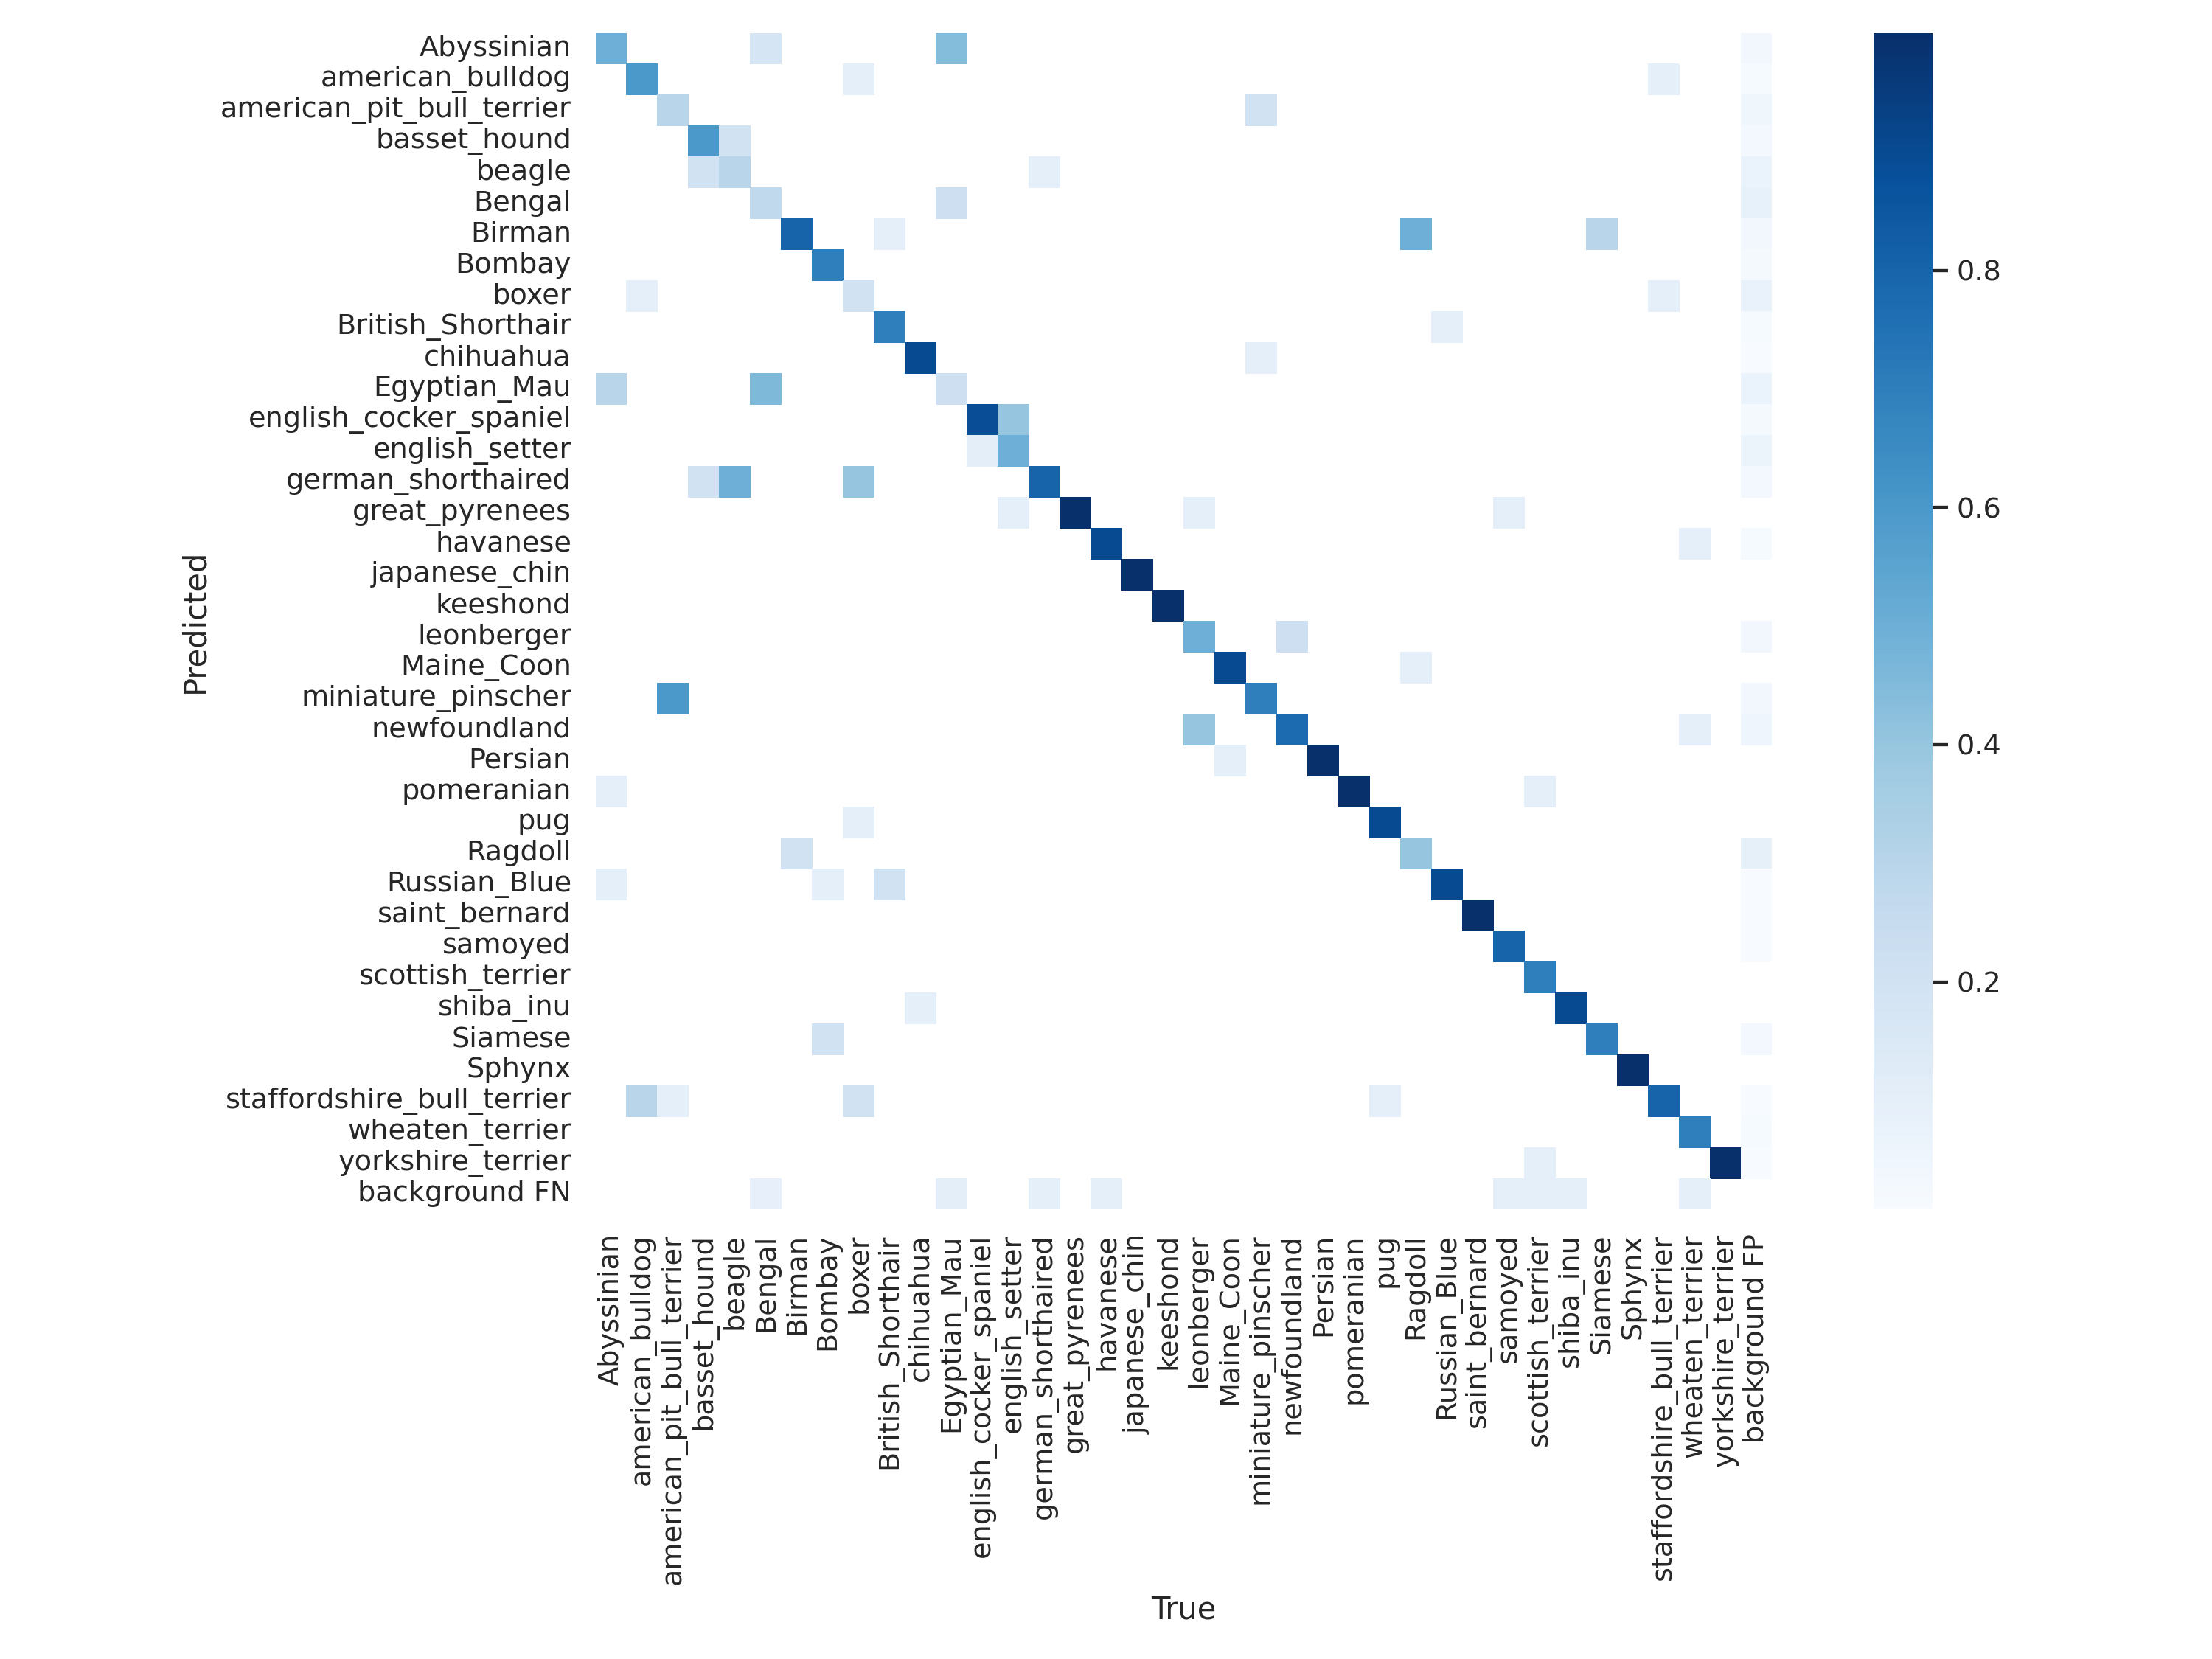

In [28]:
from IPython.display import Image

Image(filename='/content/data/output/test_result/confusion_matrix.png', width=800)